In [2]:
import numpy as np

import matplotlib.pyplot as plt

In [7]:
#Функция для генерации рандомных точек с нормальным распределением
def gen_normal(count):
    mu, sigma = 0, 0.1 # mean and standard deviation
    s = np.random.normal(mu, sigma, size=(2, count))
    return s

In [8]:
normal_points = gen_normal(100)

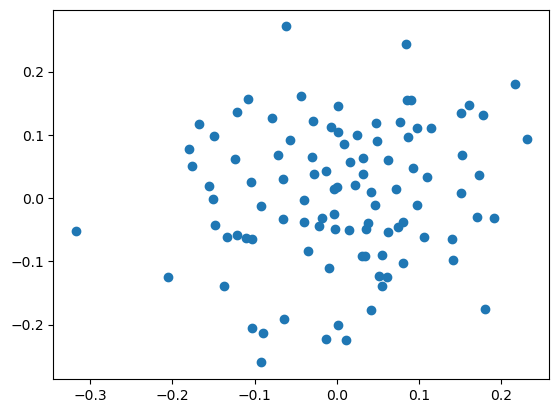

In [9]:
plt.scatter(normal_points[0], normal_points[1])
plt.show()

In [14]:
#Функция для генерации рандомных точек с равномерным распределением
def gen_uniform(count):
    low, high = -0.2, 0.2
    s = np.random.uniform(low, high, size=(2, count))
    return s

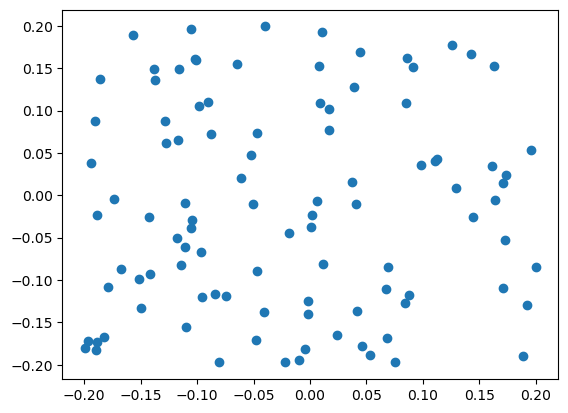

In [15]:
uniform_points = gen_uniform(100)
plt.scatter(uniform_points[0], uniform_points[1])
plt.show()